In [115]:
import numpy as np
import pandas as pd
from google.colab import drive
import sys
import seaborn as sns
import matplotlib.pyplot as plt

#For woring in Google Colab Directory
drive.mount('/content/gdrive/', force_remount=True)
sys.path.append('/content/gdrive/My Drive/COMP 642/proj/')
path = '/content/gdrive/My Drive/COMP 642/proj/'

import prepare_edr
import tensorflow as tf
import keras


Mounted at /content/gdrive/


In [116]:
#load data from our pre-processing class
test_data = prepare_edr.PrepareEDR(path + "well_1.csv")
#Architecture contains the scaler so we can quickly back-out the original data if we wanted to.
time_steps = 20
X_train_ts, y_train_ts, X_test_ts, y_test_ts, X_test_orig, headers_X, headers_y, data_scaler = test_data.getLateralTimeSeriesData(13000, 15000, time_steps)

#We use the historical "time_steps" worth of points to predict the point at index [time_steps]
X_test_orig = X_test_orig[time_steps:]


#Now we have a 3D tensor of shape: samples, time steps, features. 

print(X_train_ts.shape)
print(y_train_ts.shape)
print(X_test_ts.shape)
print(y_test_ts.shape)

(931, 20, 9)
(931,)
(218, 20, 9)
(218,)


In [117]:
#Keras / Tensorflow2 RNN implementation - LSTM
keras.backend.clear_session

#Need input_shape argument passed to the first layer.
#To stack LSTM layers, we need to configure the prior LSTM layer to return_sequences to True. 
#This will return 1 output for each input time step and provide a 3D array.
RNN_model = keras.models.Sequential([                                
                                     keras.layers.LSTM(150, activation="tanh", return_sequences=True,
                                                       input_shape=(X_train_ts.shape[1], X_train_ts.shape[2])),
                                     keras.layers.LSTM(50, activation="tanh"),
                                     keras.layers.Dense(1)  
])
RNN_model.summary()
#keras.utils.plot_model(RNN_model)

RNN_model.compile(
    loss='mean_squared_error',
    optimizer=keras.optimizers.Adam(learning_rate=0.005)
)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 20, 150)           96000     
_________________________________________________________________
lstm_30 (LSTM)               (None, 50)                40200     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 51        
Total params: 136,251
Trainable params: 136,251
Non-trainable params: 0
_________________________________________________________________


In [118]:
#Model parameters
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 8, restore_best_weights=True)
batch_size = 16
validation_split = 0.1
epochs = 100

#With RNN model, make sure that we don't shuffle the 
RNN_model_history = RNN_model.fit(X_train_ts, y_train_ts, 
                                  epochs=epochs, batch_size=batch_size,
                                  validation_split=validation_split, shuffle=False,
                                  verbose=1,
                                  callbacks=[early_stopping_cb])

Train on 837 samples, validate on 94 samples
Epoch 1/100
837/837 [==============================] - 3s 3ms/step - loss: 0.1492 - val_loss: 0.0227
Epoch 2/100
837/837 [==============================] - 2s 2ms/step - loss: 0.0402 - val_loss: 0.0126
Epoch 3/100
837/837 [==============================] - 2s 2ms/step - loss: 0.0336 - val_loss: 0.0230
Epoch 4/100
837/837 [==============================] - 2s 2ms/step - loss: 0.0311 - val_loss: 0.0161
Epoch 5/100
837/837 [==============================] - 2s 3ms/step - loss: 0.0314 - val_loss: 0.0154
Epoch 6/100
837/837 [==============================] - 2s 2ms/step - loss: 0.0285 - val_loss: 0.0120
Epoch 7/100
837/837 [==============================] - 2s 2ms/step - loss: 0.0246 - val_loss: 0.0094
Epoch 8/100
837/837 [==============================] - 2s 2ms/step - loss: 0.0229 - val_loss: 0.0090
Epoch 9/100
837/837 [==============================] - 2s 2ms/step - loss: 0.0225 - val_loss: 0.0102
Epoch 10/100
837/837 [========================

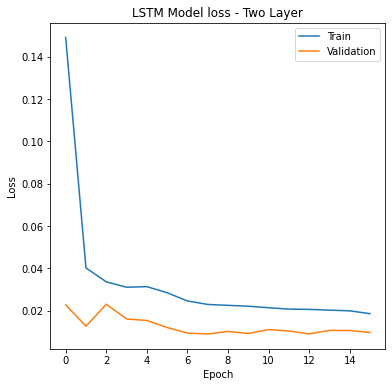

In [124]:
plt.figure(figsize=(6,6))
plt.plot(RNN_model_history.history['loss'])
plt.plot(RNN_model_history.history['val_loss'])
plt.title('LSTM Model loss - Two Layer')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [120]:
y_est = RNN_model.predict(X_test_ts)
y_est.shape

(218, 1)

In [121]:
#Instead of transforming back to the original X_test data, just pass the normalized
#X_test data from our data preparation class before it was shape-changed (look back)

#This was passed from the original method call getLateralTimeSeriesData, assigned to a value
# X_test_orig

#Once this data 
from math import sqrt
from sklearn.metrics import mean_squared_error
test_set = np.concatenate((X_test_orig, np.expand_dims(y_test_ts, axis=1)), axis=1)
test_set_predicted = np.concatenate((X_test_orig, y_est), axis=1)

test_inv = data_scaler.inverse_transform(test_set)
y_test_inv = test_inv[:,9]
y_est_inv = data_scaler.inverse_transform(test_set_predicted)[:,9]

headers_with_estimates = np.append(headers_X, ["ROP", "Estimated ROP"])
test_set_with_estimates = pd.DataFrame(data = np.concatenate((test_inv, np.expand_dims(y_est_inv, axis=1)), axis=1), 
                                                             columns = headers_with_estimates)


rmse = sqrt(mean_squared_error(y_test_inv, y_est_inv))
print('Test RMSE: %.2f' % rmse)
test_set_with_estimates

Test RMSE: 74.66


,Bit Depth / Hole Depth,Rotary RPM,Weight on Bit,Total Pump Output,Block Movement: + / - / 0,Differential Pressure,Hook Load,Standpipe Pressure,Convertible Torque,ROP,Estimated ROP
0,1.000000,68.41,17.1,349.29,-1.0,475.02,236.6,5265.91,13.906,174.68,85.291751
1,1.000000,119.73,22.7,349.29,-1.0,607.94,229.2,5398.84,15.253,276.12,239.653760
2,1.000000,119.78,31.2,348.68,-1.0,1012.15,222.9,5803.04,16.724,385.01,310.467976
3,1.000000,119.75,32.6,349.29,-1.0,1108.06,217.4,5898.94,17.688,377.54,375.967682
4,1.000000,119.78,32.8,348.68,-1.0,1168.63,215.4,5959.52,17.397,386.51,359.468322
...,...,...,...,...,...,...,...,...,...,...,...
213,0.689359,0.05,0.0,0.00,-1.0,0.00,54.7,0.00,0.000,0.00,-111.086685
214,0.693523,0.05,0.0,0.00,-1.0,0.00,54.1,0.00,0.000,0.00,-111.759292
215,0.695309,0.05,0.0,0.00,-1.0,0.00,54.7,0.00,0.000,0.00,-112.237771
216,0.695309,0.05,0.0,0.00,0.0,0.00,53.2,0.00,0.000,0.00,-112.365709


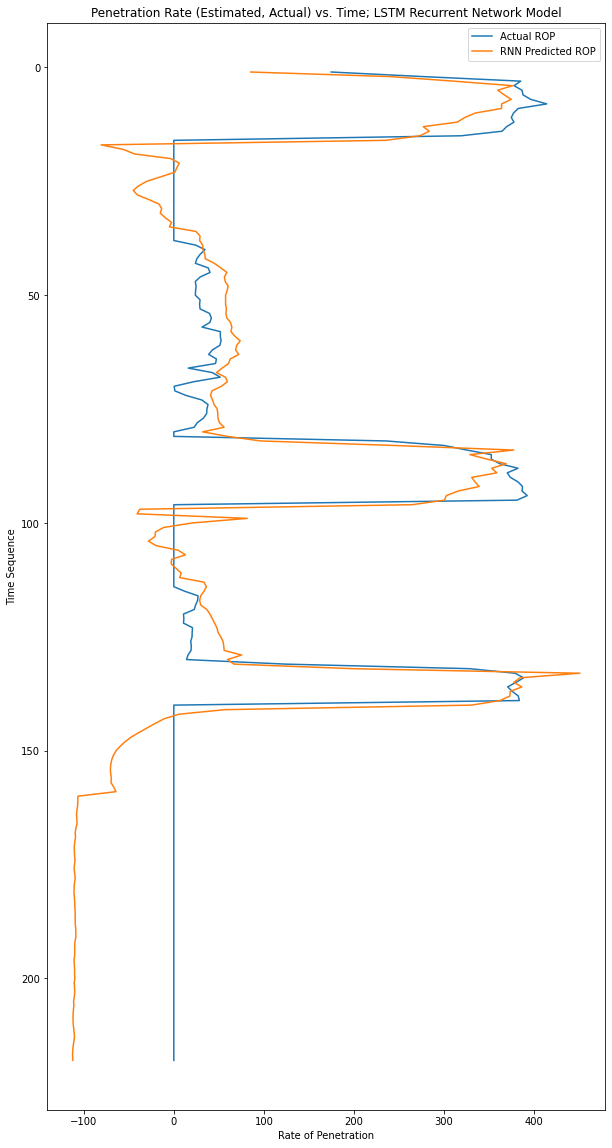

In [123]:
time_estimate_ROP = range(1, len(test_set_with_estimates) + 1)
plt.figure(figsize=(10,20))
plt.gca().invert_yaxis()
plt.plot("ROP", time_estimate_ROP, data=test_set_with_estimates)
plt.plot("Estimated ROP", time_estimate_ROP, data=test_set_with_estimates)
plt.legend(['Actual ROP', 'RNN Predicted ROP'])
plt.title('Penetration Rate (Estimated, Actual) vs. Time; LSTM Recurrent Network Model')
plt.xlabel('Rate of Penetration')
plt.ylabel('Time Sequence')
plt.show()